In [37]:
# import the necessary packages
# https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset/metadata
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.applications.mobilenet_v3 import MobileNetV3Small, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical #Converts a class vector (integers) to binary class matrix
from sklearn.preprocessing import LabelBinarizer #accepts Categorical data as input and returns an Numpy array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [38]:
dataset_path = "./Dataset"
datas = []
labels = []

categories = ["Mask", "withoutMask"]
for category in categories:
    path = os.path.join(dataset_path, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = preprocess_input(img_to_array(load_img(img_path, target_size=(224, 224, 3))))
        datas.append(image)
        labels.append(category)

# change the labals to 0 and 1s
labels = to_categorical(LabelBinarizer().fit_transform(labels))


In [39]:
datas = np.array(datas, dtype="float32")
labels = np.array(labels)

In [40]:
(trainX, testX, trainY, testY) = train_test_split(datas, labels, test_size=0.20, stratify=labels, random_state=42)

In [41]:
INIT_LR = 0.0001
EPOCHS = 27
BATCH_SIZE = 32

In [42]:
# # load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(baseModel)
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten(name="flatten"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
# model.add(Dense(32, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

# compile our model
model.compile(loss='binary_crossentropy', 
              optimizer = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_3 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 2)                

In [43]:
# #stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.

# construct the training image generator for data augmentation
datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.25,
                height_shift_range=0.2,
                fill_mode="nearest",
                shear_range=0.2,
                horizontal_flip=True)

In [44]:
# train the head of the network
print("[INFO] training head...")
result = model.fit(
				datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
				steps_per_epoch=(len(trainX) // BATCH_SIZE),
				validation_data=(testX, testY),
				validation_steps=(len(testX) // BATCH_SIZE),
				epochs=EPOCHS)

[INFO] training head...
Epoch 1/27
25/25 [==============================] - 54s 2s/step - loss: 0.3543 - accuracy: 0.8692 - val_loss: 0.1807 - val_accuracy: 0.9356
Epoch 2/27
25/25 [==============================] - 48s 2s/step - loss: 0.0724 - accuracy: 0.9793 - val_loss: 0.0574 - val_accuracy: 0.9802
Epoch 3/27
25/25 [==============================] - 48s 2s/step - loss: 0.0245 - accuracy: 0.9974 - val_loss: 0.0435 - val_accuracy: 0.9802
Epoch 4/27
25/25 [==============================] - 49s 2s/step - loss: 0.0161 - accuracy: 0.9974 - val_loss: 0.0497 - val_accuracy: 0.9752
Epoch 5/27
25/25 [==============================] - 49s 2s/step - loss: 0.0112 - accuracy: 0.9974 - val_loss: 0.0720 - val_accuracy: 0.9802
Epoch 6/27
25/25 [==============================] - 49s 2s/step - loss: 0.0226 - accuracy: 0.9909 - val_loss: 0.0596 - val_accuracy: 0.9752
Epoch 7/27
25/25 [==============================] - 49s 2s/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.0372 - val_accuracy: 0.9

In [45]:
# save the model
model.save("face_detector/mask_detector.model", save_format="h5")

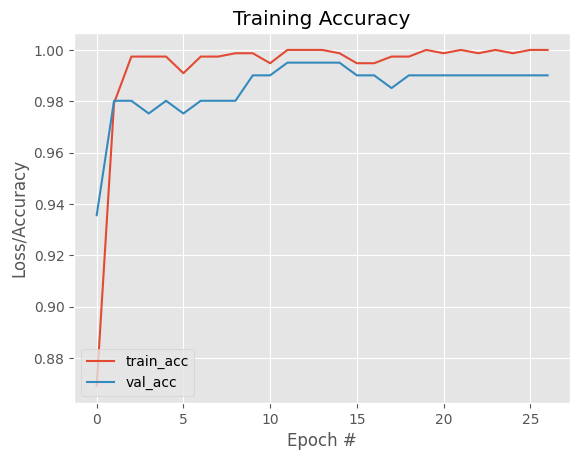

In [46]:
# plot the training accuracy

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), result.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), result.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

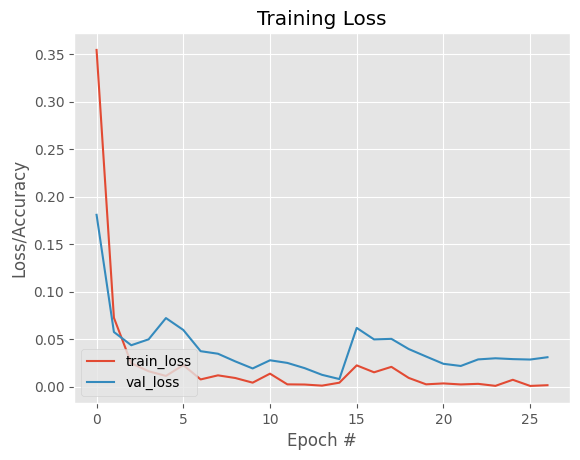

In [47]:
# plot the training loss

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), result.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

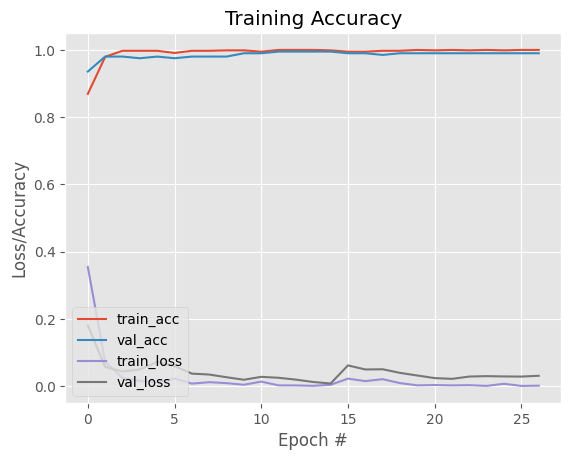

In [48]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), result.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), result.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, EPOCHS), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), result.history["val_loss"], label="val_loss")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()